In [158]:
import sys 
sys.dont_write_bytecode = True # Stop creating __pycache__ folder

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from toolbox import *

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Loading the data set

In [159]:
import pandas as pd

# Daily updated COVID database
url = 'https://covid.ourworldindata.org/data/owid-covid-data.json'
json = pd.read_json(url)

data = json['CHE']['data']
df = pd.DataFrame(data)
df.tail()

,date,total_cases,new_cases,total_cases_per_million,new_cases_per_million,stringency_index,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,...,people_vaccinated,people_fully_vaccinated,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred
632,2021-11-18,935047.0,6016.0,107285.600,690.265,50.0,4276.429,7.857,490.670,0.902,...,5807481.0,5650950.0,131.98,66.63,64.84,44105.0,29239.0,3355.0,4173.0,0.048
633,2021-11-19,941218.0,6171.0,107993.649,708.049,50.0,4597.143,7.429,527.468,0.852,...,5812577.0,5658213.0,132.51,66.69,64.92,45626.0,31807.0,3649.0,3887.0,0.045
634,2021-11-20,941218.0,0.0,107993.649,0.000,NaN,4597.143,8.143,527.468,0.934,...,5815514.0,5661837.0,132.74,66.73,64.96,20694.0,32556.0,3735.0,3637.0,0.042
635,2021-11-21,941218.0,0.0,107993.649,0.000,NaN,4597.143,8.000,527.468,0.918,...,5815865.0,5662202.0,132.79,66.73,64.97,3888.0,32747.0,3757.0,3582.0,0.041
636,2021-11-22,955810.0,14592.0,109667.909,1674.260,NaN,5294.286,8.571,607.457,0.983,...,5819538.0,5666678.0,133.26,66.77,65.02,40872.0,33811.0,3879.0,3566.0,0.041


In [160]:
for key, value in json['CHE'].items(): 
	if key != 'data':
		print(f"{key} : {value}")

print(f"\nData gathered on {len(df)} days, from {df['date'][0]} to {df['date'][len(df) - 1]}.")

continent : Europe
location : Switzerland
population : 8715494.0
population_density : 214.243
median_age : 43.1
aged_65_older : 18.436
aged_70_older : 12.644
gdp_per_capita : 57410.166
cardiovasc_death_rate : 99.739
diabetes_prevalence : 5.59
handwashing_facilities : nan
hospital_beds_per_thousand : 4.53
life_expectancy : 83.78
human_development_index : 0.9550000000000001
extreme_poverty : nan
female_smokers : 22.6
male_smokers : 28.9

Data gathered on 637 days, from 2020-02-25 to 2021-11-22.


# Preprocessing

In [161]:
df_proc = df

## Analyse des NaN

<AxesSubplot:>

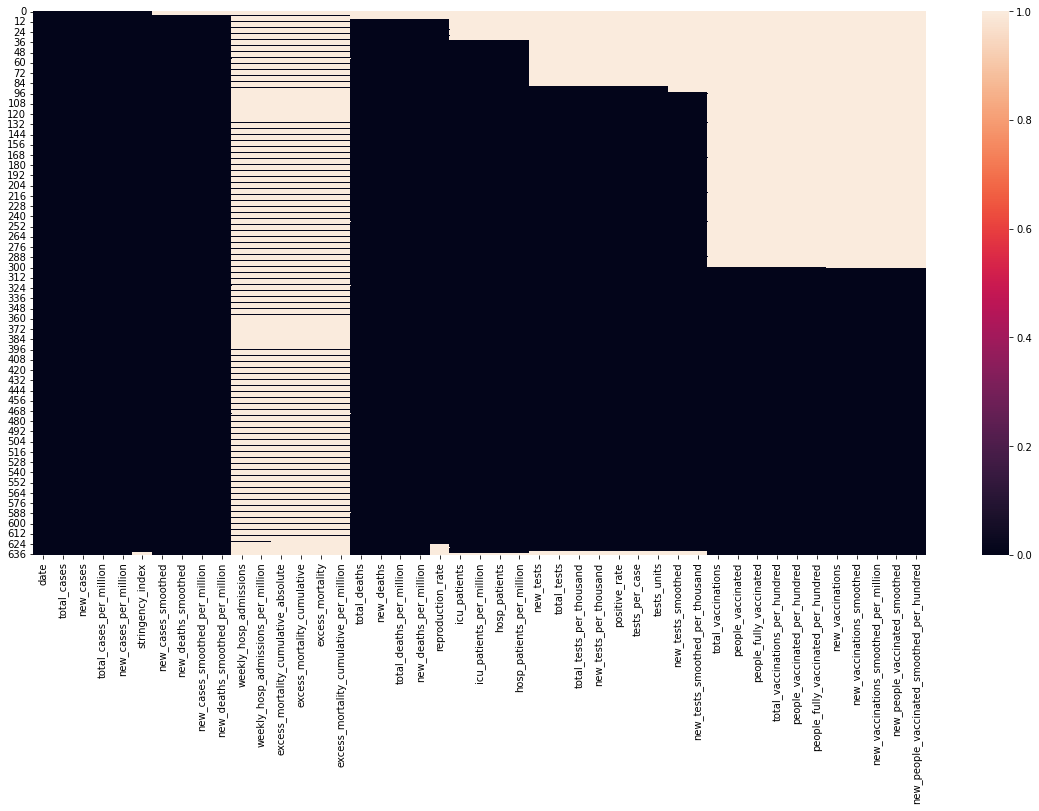

In [162]:
plt.figure(figsize=(20,10))
sns.heatmap(df_proc.isna())

# Les NaN sont en beige sur le graphe, il y en a beaucoup, mais on va pouvoir les virer par la suite

In [163]:
# On trie les différentes données pour voir lesquelles possèdent le plus de NaN
missing_rate = df.isna().sum() / df.shape[0]
print(missing_rate.sort_values(ascending=False))

# On supprime les colonnes qui ont moins de 50% des données
df_proc = df_proc.drop(df_proc.columns[missing_rate > 0.5], axis=1)

excess_mortality_cumulative                   0.861852
excess_mortality_cumulative_per_million       0.861852
excess_mortality                              0.861852
excess_mortality_cumulative_absolute          0.861852
weekly_hosp_admissions                        0.857143
weekly_hosp_admissions_per_million            0.857143
new_people_vaccinated_smoothed_per_hundred    0.472527
new_vaccinations_smoothed_per_million         0.472527
new_vaccinations                              0.472527
new_vaccinations_smoothed                     0.472527
new_people_vaccinated_smoothed                0.472527
people_vaccinated_per_hundred                 0.470958
total_vaccinations                            0.470958
total_vaccinations_per_hundred                0.470958
people_vaccinated                             0.470958
people_fully_vaccinated_per_hundred           0.470958
people_fully_vaccinated                       0.470958
new_tests_smoothed_per_thousand               0.155416
new_tests_

## Analyse des corrélations

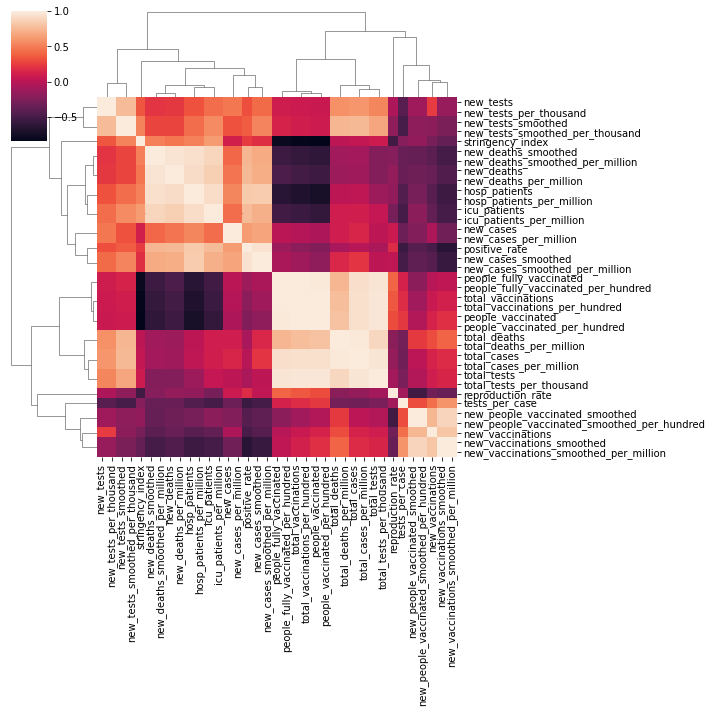

In [164]:
sns.clustermap(df_proc.corr())

In [165]:
correlations = df_proc.corr()['new_deaths']
print(correlations.sort_values(ascending=False))

new_deaths                                    1.000000
new_deaths_per_million                        1.000000
new_deaths_smoothed                           0.959063
new_deaths_smoothed_per_million               0.959062
hosp_patients_per_million                     0.922933
hosp_patients                                 0.922932
icu_patients                                  0.856984
icu_patients_per_million                      0.856984
positive_rate                                 0.757969
new_cases_smoothed                            0.710239
new_cases_smoothed_per_million                0.710239
stringency_index                              0.469726
new_cases                                     0.467766
new_cases_per_million                         0.467766
new_tests_smoothed                            0.285591
new_tests_smoothed_per_thousand               0.285590
new_tests                                     0.235058
new_tests_per_thousand                        0.235057
total_case

In [166]:
# Prendre les corrélations > 0, qui ne sont pas des doublons (per_million, smoothed, smoothed_per_million, ...)
df_proc = df_proc[['date', 'new_deaths', 'hosp_patients', 'icu_patients', 'positive_rate', 'stringency_index', 'new_cases', 'new_tests']]

In [167]:
df_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              637 non-null    object 
 1   new_deaths        627 non-null    float64
 2   hosp_patients     602 non-null    float64
 3   icu_patients      602 non-null    float64
 4   positive_rate     545 non-null    float64
 5   stringency_index  634 non-null    float64
 6   new_cases         637 non-null    float64
 7   new_tests         545 non-null    float64
dtypes: float64(7), object(1)
memory usage: 39.9+ KB


## Mise en forme

In [168]:
# Drop all the NaN values
df_proc = df_proc.dropna()
print(f"Any NaN remaining: {df_proc.isnull().sum().any()}")

# Remove rows with negative values because not possible
df_proc = df_proc[df_proc.select_dtypes(include=[np.number]).ge(0).all(1)] 

Any NaN remaining: False


In [169]:
for column in df_proc.columns:
    if column == 'date':
        continue

    fig = go.Figure([
        go.Scatter(x=df_proc['date'], y=df_proc[column])
    ])
    fig.update_layout(
        title={
            'text': column,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='date',
        yaxis_title=column,
    )
    fig.show()

Tous les lundis le nombre de nouveaux cas explose car il y a ceux du WE qui n'ont pas été additionnés pendant le WE

In [170]:
# On veut retirer l'outlier de new_deaths du 09-02-2020
df_proc = df_proc[df_proc['date'] != '2021-02-09']

In [172]:
fig = go.Figure([
    go.Scatter(x=df_proc['date'], y=df_proc['new_deaths'])
])
fig.update_layout(
    title={
        'text': column,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='date',
    yaxis_title=column,
)
fig.show()

# Testing machine learning models only using date to predict every day new deaths

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

df_used = df_proc[['date', 'new_deaths']]
df_used['date'] = df_used.index

X = df_used['date'].values.reshape(-1, 1)
X_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
X_pred = np.array(range(len(df), len(df) + 30)).reshape(-1, 1) # next month

y = df_used['new_deaths'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cv = ShuffleSplit(test_size=0.2, train_size=0.8)

## Linear Models


### Ordinary Least Squares

In [4]:
from sklearn.linear_model import LinearRegression

pipeline = Pipeline([("scaler", MinMaxScaler()), ("linear", LinearRegression())])

param_grid = {}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) # njobs for the number of CPU cores used
grid = grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Linear")

Best parameters: {}
Training set score: 0.02
Test set score: 0.03
Best cross-validation accuracy: 0.00


### Ridge regression

In [117]:
from sklearn.linear_model import Ridge

pipeline = Pipeline([("scaler", MinMaxScaler()), ("ridge", Ridge())])

param_grid = {
	'ridge__alpha': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Ridge")

Best parameters: {'ridge__alpha': 0.1}
Training set score: 0.02
Test set score: 0.03
Best cross-validation accuracy: 0.00


### Lasso

In [118]:
from sklearn.linear_model import Lasso

pipeline = Pipeline([("scaler", MinMaxScaler()), ("lasso", Lasso())])

param_grid = {
	'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Lasso")

Best parameters: {'lasso__alpha': 0.001}
Training set score: 0.02
Test set score: 0.03
Best cross-validation accuracy: -0.01


### Logistic Regression

In [119]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([("scaler", MinMaxScaler()), ("logistic", LogisticRegression())])

param_grid = {
	'logistic__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Logistic")

Best parameters: {'logistic__C': 0.001}
Training set score: 0.18
Test set score: 0.15
Best cross-validation accuracy: 0.18


## Naive Bayes Classifiers

### Gaussian

In [120]:
from sklearn.naive_bayes import GaussianNB

pipeline = Pipeline([("scaler", MinMaxScaler()), ("gaussian", GaussianNB())])

param_grid = {}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Gaussian")

Best parameters: {}
Training set score: 0.29
Test set score: 0.15
Best cross-validation accuracy: 0.19


### Multinomial

In [22]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([("scaler", MinMaxScaler()), ("multinomial", MultinomialNB())])

param_grid = {
	'multinomial__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train[:, 0], X_test[:, 0], X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Multinomial")

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Best parameters: {'multinomial__alpha': 0.001}
Training set score: 0.20
Test set score: 0.19
Best cross-validation accuracy: 0.20


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:101: FutureWarning:

Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).



## K-Nearest Neighbors

In [124]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor())])

param_grid = {
	'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Knn")

Best parameters: {'knn__n_neighbors': 10}
Training set score: 0.94
Test set score: 0.96
Best cross-validation accuracy: 0.95


## Decision Trees

### Simple Decision Trees

In [125]:
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("tree", DecisionTreeRegressor())])

param_grid = {
	'tree__criterion': ["squared_error", "absolute_error", "poisson", "friedman_mse"], 
	'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Decision tree")

Best parameters: {'tree__criterion': 'friedman_mse', 'tree__max_depth': 5}
Training set score: 0.96
Test set score: 0.93
Best cross-validation accuracy: 0.90


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.00872768 0.01456739
 0.02399891 0.09500216 0.13895039 0.2337114  0.36521317 0.50277259
 0.58670978 0.65033427 0.89143667 0.13986859 0.67999393 0.85231618
 0.88559809 0.89903385 0.89739377 0.89451082 0.89272902 0.89269491
 0.89117895 0.89070821]



### Random Forest

In [126]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("forest", RandomForestRegressor())])

param_grid = {
	'forest__criterion': ["squared_error", "absolute_error", "poisson"], 
	'forest__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
	'forest__n_estimators': [1, 5, 10, 50, 100, 500, 1000]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Random forest")

Best parameters: {'forest__criterion': 'poisson', 'forest__max_depth': None, 'forest__n_estimators': 50}
Training set score: 0.99
Test set score: 0.95
Best cross-validation accuracy: 0.94


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan  

### Gradient Boosted Trees

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("gradient_boosting", GradientBoostingRegressor())])

param_grid = {
	'gradient_boosting__criterion': ["squared_error", "friedman_mse"], 
	'gradient_boosting__loss': ["squared_error", "absolute_error", "huber", "quantile"], 
	'gradient_boosting__n_estimators': [1, 5, 10, 50, 100, 500, 1000], 
	'gradient_boosting__learning_rate': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "Gradient boosted trees")

C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [             nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              n

Best parameters: {'gradient_boosting__criterion': 'friedman_mse', 'gradient_boosting__learning_rate': 0.01, 'gradient_boosting__loss': 'huber', 'gradient_boosting__n_estimators': 1000}
Training set score: 0.96
Test set score: 0.95
Best cross-validation accuracy: 0.93


## Support Vector Regression

In [128]:
from sklearn.svm import SVR

pipeline = Pipeline([("scaler", MinMaxScaler()), ("svr", SVR())])

param_grid = {
	'svr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
	'svr__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "SVR")

Best parameters: {'svr__C': 100, 'svr__gamma': 1000}
Training set score: 0.94
Test set score: 0.96
Best cross-validation accuracy: 0.95


## Multi-Layer Perceptrons (Deep Learning)

In [129]:
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("mlp", MLPRegressor())])

param_grid = {
	'mlp__hidden_layer_sizes': [1, 10, 100, 1000], 
	'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
	'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'], 
	'mlp__solver': ['lbfgs', 'sgd', 'adam'], 
	'mlp__max_iter': [1000]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot_squeeze(X_train, X_test, X_range, X_pred, y_train, y_test, grid.predict(X_range), grid.predict(X_pred), "MLP")

Best parameters: {'mlp__activation': 'tanh', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': 100, 'mlp__max_iter': 1000, 'mlp__solver': 'lbfgs'}
Training set score: 0.94
Test set score: 0.96
Best cross-validation accuracy: 0.90


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



# Testing machine learning models with multiple features to predict every day new deaths

In [34]:
df_used = df_proc
df_used['date'] = pd.to_datetime(df_used['date'])
df_used = df_used.set_index('date')

Décaler les y vers la gauche pour pouvoir prédire sur le mois d'après

Knn pour prédire la forme des features, et ensuite utiliser ces features approximée pour approximer la feature à prédire

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

X_train = df_used[:'2021-09'].drop(['new_deaths'], axis = 1)
y_train = df_used.loc[:'2021-09', 'new_deaths']

X_test = df_used['2021-10':].drop(['new_deaths'], axis = 1)
y_test = df_used.loc['2021-10':, 'new_deaths']

cv = TimeSeriesSplit(n_splits=10)

## K-Nearest Neighbors

In [4]:
from sklearn.neighbors import KNeighborsRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor())])

param_grid = {
	'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train.index, X_test.index, X_train.index, X_test.index, y_train, y_test, grid.predict(X_train), grid.predict(X_test), "Knn")
regression_results(y_test.values, grid.predict(X_test))

Best parameters: {'knn__n_neighbors': 1}
Training set score: 1.00
Test set score: -1.31
Best cross-validation accuracy: -2.24


explained_variance:  -0.8394
mean_squared_log_error:  2.6816
mean_squared_absolute_error:  5.0
r2:  -1.31
MAE:  6.1081
MSE:  56.9189
RMSE:  7.5445


## Decision Trees

### Simple Decision Trees

In [5]:
from sklearn.tree import DecisionTreeRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("tree", DecisionTreeRegressor())])

param_grid = {
	'tree__criterion': ["squared_error", "absolute_error", "poisson", "friedman_mse"], 
	'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1) 
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train.index, X_test.index, X_train.index, X_test.index, y_train, y_test, grid.predict(X_train), grid.predict(X_test), "Decision tree")
regression_results(y_test.values, grid.predict(X_test))

Best parameters: {'tree__criterion': 'friedman_mse', 'tree__max_depth': 1}
Training set score: 0.84
Test set score: -0.00
Best cross-validation accuracy: -4.04


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan -78.44193292 -72.36267696 -62.56365778
 -81.05498685 -63.07386266 -68.91630353 -49.52488943 -62.22195028
 -44.55814699 -43.66618901 -57.65297322  -4.04462693 -14.74450084
 -26.25494102 -29.83891863 -36.01895753 -25.95127713 -23.81736868
 -31.48242208 -24.92606095 -23.65292203 -52.33564059]



explained_variance:  0.0
mean_squared_log_error:  0.9491
mean_squared_absolute_error:  4.1376
r2:  -0.0001
MAE:  4.0064
MSE:  24.6425
RMSE:  4.9641


### Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("forest", RandomForestRegressor())])

param_grid = {
	'forest__criterion': ["squared_error", "absolute_error", "poisson"], 
	'forest__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 
	'forest__n_estimators': [1, 5, 10, 50, 100, 500, 1000]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train.index, X_test.index, X_train.index, X_test.index, y_train, y_test, grid.predict(X_train), grid.predict(X_test), "Random forest")
regression_results(y_test.values, grid.predict(X_test))

Best parameters: {'forest__criterion': 'poisson', 'forest__max_depth': 10, 'forest__n_estimators': 10}
Training set score: 0.86
Test set score: -0.08
Best cross-validation accuracy: -34.09


C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan    

explained_variance:  0.0
mean_squared_log_error:  1.1007
mean_squared_absolute_error:  3.5608
r2:  -0.0764
MAE:  4.3829
MSE:  26.5213
RMSE:  5.1499


### Gradient Boosted Trees

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("gradient_boosting", GradientBoostingRegressor())])

param_grid = {
	'gradient_boosting__criterion': ["squared_error", "friedman_mse"], 
	'gradient_boosting__loss': ["squared_error", "absolute_error", "huber", "quantile"], 
	'gradient_boosting__n_estimators': [1, 5, 10, 50, 100, 500, 1000], 
	'gradient_boosting__learning_rate': [0, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train.index, X_test.index, X_train.index, X_test.index, y_train, y_test, grid.predict(X_train), grid.predict(X_test), "Gradient boosted trees")
regression_results(y_test.values, grid.predict(X_test))

C:\Users\leon.muller\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [             nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              nan
              nan              nan              nan              n

Best parameters: {'gradient_boosting__criterion': 'friedman_mse', 'gradient_boosting__learning_rate': 0.001, 'gradient_boosting__loss': 'huber', 'gradient_boosting__n_estimators': 500}
Training set score: 0.51
Test set score: -0.36
Best cross-validation accuracy: -3.74


explained_variance:  -0.0945
mean_squared_log_error:  0.9758
mean_squared_absolute_error:  3.1433
r2:  -0.3555
MAE:  4.6415
MSE:  33.3992
RMSE:  5.7792


## Support Vector Regression

In [9]:
from sklearn.svm import SVR

pipeline = Pipeline([("scaler", MinMaxScaler()), ("svr", SVR())])

param_grid = {
	'svr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
	'svr__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train.index, X_test.index, X_train.index, X_test.index, y_train, y_test, grid.predict(X_train), grid.predict(X_test), "SVR")
# regression_results(y_test.values, grid.predict(X_test))

Best parameters: {'svr__C': 100, 'svr__gamma': 1}
Training set score: 0.95
Test set score: -3.57
Best cross-validation accuracy: -2.28


## Multi-Layer Perceptrons (Deep Learning)

In [ ]:
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline([("scaler", MinMaxScaler()), ("mlp", MLPRegressor())])

param_grid = {
	'mlp__hidden_layer_sizes': [1, 10, 100, 1000], 
	'mlp__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
	'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'], 
	'mlp__solver': ['lbfgs', 'sgd', 'adam'], 
	'mlp__max_iter': [1000]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Best parameters: {grid.best_params_}")
print(f"Training set score: {grid.score(X_train, y_train):.2f}")
print(f"Test set score: {grid.score(X_test, y_test):.2f}")
print(f"Best cross-validation accuracy: {grid.best_score_:.2f}")
scatter_plot(X_train.index, X_test.index, X_train.index, X_test.index, y_train, y_test, grid.predict(X_train), grid.predict(X_test), "MLP")
regression_results(y_test.values, grid.predict(X_test))

# Shit

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
	tscv = TimeSeriesSplit(n_splits=10)
		
	cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
import plotly.express as ex
from sklearn.linear_model import LinearRegression

dff = ex.data.iris()

Xi = dff.drop(columns=['petal_width', 'species_id'])
Xi = pd.get_dummies(Xi, columns=['species'], prefix_sep='=')
yi = dff['petal_width']

model = LinearRegression()
model.fit(Xi, yi)

colors = ['Positive' if c > 0 else 'Negative' for c in model.coef_]

fig = ex.bar(
    x=Xi.columns, y=model.coef_, color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Feature', y='Linear coefficient'),
    title='Weight of each feature for predicting petal width'
)
fig.show()


# print(grid.best_estimator_.named_steps['linear'].coef_)